# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#additionally...
import chardet

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [2]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/parser already exists, skipping download
../stanford-NLP/ner already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
../stanford-NLP/core already exists, skipping download
Done setting up the Stanford NLP collection


We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [3]:
import lucem_illud.stanford as stanford

/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [4]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [5]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [6]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [7]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

,author,over_18,score,subreddit,text,title,url,sentences
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [8]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [9]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [10]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 ('time', 14),
 (')', 14),
 ('lot', 12),
 ('computer', 12),
 ('life', 11),
 ('email', 11),
 ('**Genius**', 10),
 ('message', 9),
 ('**Me**', 9),
 ('system', 9),
 ('day', 9),
 ('call', 8),
 ('laptop', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7)]

What about the number of top verbs (`VB`)?

In [11]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('help', 6),
 ('look', 6),
 ('tell', 6),
 ('send', 6),
 ('go', 5),
 ('work', 4),
 ('use', 4),
 ('receive', 4),
 ('thank', 4),
 ('feel', 4),
 ('want', 4),
 ('call', 4)]

What about the adjectives that modify the word, "computer"?

In [12]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [13]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [14]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [15]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [16]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [6]:
#get corpus of 26 DOS speeches
DOSSpeeches = '/Users/Enya/Desktop/DOS_Speeches.csv'
DOSSpeechesDF = pandas.read_csv(DOSSpeeches, encoding='Latin-1')
print (DOSSpeechesDF)

        date                                              title  \
0    12/1/16  Preventing the Exploitation of Information and...   
1   10/10/16  Keynote Address at the Singapore International...   
2    9/28/16  The Persistent Threat of North Korea and Devel...   
3    9/19/16  Statement Before the Presidential Commission o...   
4     6/3/16                                   TEDx Tysons Talk   
5    5/25/16  International Cybersecurity Strategy: Deterrin...   
6     3/1/16  Remarks by Attorney General Loretta E. Lynch a...   
7    2/26/16  Inter-American Committee Against Terrorism (CI...   
8    2/11/16  The New Face of Terrorism: Countering Violent ...   
9    7/29/15  Remarks for Panel Session "Development of Cybe...   
10    5/4/15  Department of Commerce Cybersecurity Trade Mis...   
11   2/24/15                      New Reward for Cyber Fugitive   
12   1/13/15  The North Korean Threat: Nuclear, Missiles and...   
13    3/4/14  As Prepared Remarks at Georgetown University I..

In [7]:
DOSSpeechesDF['tokenized-text'] = DOSSpeechesDF['text'].apply(lambda x: nltk.word_tokenize(x))

In [8]:
DOSSpeechesDF['sentences'] = DOSSpeechesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
DOSSpeechesDF['POS-sents'] = DOSSpeechesDF['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [9]:
DOSSpeechesDF['POS-sents']

0     [[(I, PRP), (would, MD), (like, VB), (to, TO),...
1     [[(Good, JJ), (morning, NN), (!, .)], [(Thank,...
2     [[(Introduction, NN), (., .)], [(Chairman, NNP...
3     [[(Chairman, NNP), (Donilon, NNP), (,, ,), (Vi...
4     [[(So, RB), (what, WP), (do, VBP), (zombies, N...
5     [[(Chairman, NNP), (Gardner, NNP), (,, ,), (Ra...
6     [[(Good, JJ), (afternoon, NN), (,, ,), (and, C...
7     [[(Background, NN), (:, :), (The, DT), (Sixtee...
8     [[(Good, JJ), (afternoon, NN), (., .)], [(IÍm,...
9     [[(Thank, VB), (you, PRP), (for, IN), (the, DT...
10    [[(Great, JJ), (., .)], [(Well, RB), (,, ,), (...
11    [[(ASSISTANT, NNP), (ATTORNEY, NNP), (GENERAL,...
12    [[(Mr., NNP), (Chairman, NNP), (,, ,), (Rankin...
13    [[(ItÍs, VBZ), (a, DT), (pleasure, NN), (to, T...
14    [[(MODERATOR, NN), (:, :), (Good, JJ), (aftern...
15    [[(Good, JJ), (morning, NN), (,, ,), (Minister...
16    [[(MODERATOR, NN), (:, :), (Good, JJ), (aftern...
17    [[(I, PRP), (am, VBP), (delighted, JJ), (t

In [10]:
countTarget = 'NN'
targetCounts = {}
for entry in DOSSpeechesDF['POS-sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:25]

[('cyber', 265),
 ('cyberspace', 202),
 ('law', 145),
 ('security', 123),
 ('world', 84),
 ('policy', 83),
 ('information', 82),
 ('internet', 73),
 ('', 71),
 ('behavior', 69),
 ('space', 66),
 ('today', 64),
 ('cooperation', 63),
 ('state', 63),
 ('stability', 63),
 ('capacity', 56),
 ('technology', 52),
 ('Internet', 51),
 ('work', 49),
 ('consensus', 48),
 ('development', 48),
 ('time', 46),
 ('role', 45),
 ('building', 45),
 ('cybersecurity', 45)]

In [11]:
countTarget = 'VB'
targetCounts = {}
for entry in DOSSpeechesDF['POS-sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:25]

[('be', 166),
 ('do', 52),
 ('build', 49),
 ('promote', 46),
 ('continue', 45),
 ('have', 39),
 ('work', 34),
 ('take', 34),
 ('make', 34),
 ('ensure', 33),
 ('Thank', 30),
 ('address', 29),
 ('engage', 26),
 ('help', 22),
 ('strengthen', 20),
 ('thank', 19),
 ('protect', 18),
 ('bring', 18),
 ('achieve', 18),
 ('apply', 18),
 ('play', 17),
 ('develop', 17),
 ('reduce', 17),
 ('see', 16),
 ('counter', 15)]

In [12]:
NTarget = 'JJ'
Word = 'cyberspace'
NResults = set()
for entry in DOSSpeechesDF['POS-sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'secure', 'international', 'military', 'reliable', 'accessible', 'key', 'stable', 'mainstream', 'peaceful', 'domestic'}


My BA research is concerned with the changing discourse of cyber in government speeches. I will focusing on the concept of cyberspace. These findings, so far, are interesting in thinking how government officials are characterizing the ambiguous entity of cyberspace. The adjectives that stand out to me are 'accessible' 'mainstream' and both domestic and international. Given its ambiguous nature, I want to answer whether or not there is an attempt to territorialize cyberspace.

In [13]:
NTarget = 'JJ'
Word = 'cyber'
NResults = set()
for entry in DOSSpeechesDF['POS-sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'sophisticated', 'global', 'specific', 'sub-regional', 'first', 'states/International', 'joint', 'foreign', 'particular', 'international', 'recent', 'transnational', 'whole-of-government', 'other', 'specialized', 'major', 'malicious', 'regional', 'voluntary', 'practical', 'complicated', 'new', 'future', 'serious', 'bilateral', 'hostile', 'large-scale', 'potential', 'cross-cutting', 'coercive', 'reliable', 'big', 'fundamental', 'significant', 'offensive'}


When looking at cyber more broadly, a few of the associated adjectives stand out. Specifically, adjectives such as "new" and "first" highlight the novelty of the phenomenon, possibly suggesting an attempt to better define the concept. I think it's interesting that offensive comes up, while defensive does not - this indicates that government officials are strategically thinking about cyber as an offensive tool. The international community is definately an important component of cyber, given the appearance of international and foreign. 

In [14]:
NTarget = 'NN'
Word = 'security'
NResults = set()
for entry in DOSSpeechesDF['POS-sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'chain', 'computer', 'document', 'network', 'cyber', 'space', 'aviation'}


In thinking more broadly about cyber's relation to security, I find it intersting that security is being discussed in relation to not only cyber, but also aviation, computer, and space. These nouns may provide further insights into the conceptualization of cyber in relation to them. I also find it interesting that aviation is present, given the ambiguity of outer space, which has similaritites to the ambiguity of cyberspace. 

In [15]:
NTarget = 'JJ'
Word = 'security'
NResults = set()
for entry in DOSSpeechesDF['POS-sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'international', 'regional', 'national', 'hemispheric', 'economic', 'private-sector', 'trilateral', 'multinational', 'shared', 'cyber', 'new', 'knowledgeable'}


This hints at the various layers, and inevitably, actors within the broader field of security. However, I think that it is important to note the presence of cyber and new, given my project's focus on this phenomenon.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [27]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [28]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [29]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [30]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or those occurring only twice:

In [31]:
[x[0] for x in sortedEntities if x[1] == 2]

['year',
 'Desk',
 'busy',
 'fix',
 'received',
 'couple',
 'Windows',
 'anymore',
 'Sure',
 'error',
 'DVD',
 'opened',
 'There',
 'upside',
 'local',
 'bane',
 'existence',
 'learn',
 'sometimes',
 'generic',
 'Everyone',
 'login',
 'times',
 'guy',
 'asset',
 'name',
 'Computer',
 'nothing',
 "'P4ssword",
 'P',
 'Everything',
 'case',
 '*type',
 'S',
 'LOWERCASE',
 'used',
 'four',
 'Original',
 'cancer',
 'month',
 'live',
 'brave',
 'bitter',
 'passed',
 'ago',
 'absolutely',
 'ready',
 'proud',
 'above',
 'completely',
 'its',
 'meant',
 'both',
 'sharing',
 'making',
 '100',
 'share',
 'looking',
 'ALL',
 'whom',
 'business',
 'whose',
 'stronger',
 'bad',
 'mess',
 'turn',
 'first',
 'others',
 'Here',
 'suggested',
 'videos',
 'While',
 'stand',
 'certain',
 'enjoy',
 'well',
 'drowned',
 'soon',
 'understand',
 'risks',
 'myself',
 'point',
 'future',
 'avoid',
 'thinking',
 'information',
 'insurance',
 'site',
 'step',
 'guide',
 'discover',
 'order',
 '5',
 'slightly',
 's

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [32]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('Citrix', 1),
 ('Nono', 1),
 ('Reddit', 1),
 ('Helpdesk', 1),
 ('UK', 1),
 ('CMD', 1)]

What about the Organizations?

In [33]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Google', 6), ('Citrix', 1), ('Helpdesk', 1), ('CMD', 1), ('GOOGLE', 1)]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

In [18]:
DOSSpeechesDF['classified-sents'] = DOSSpeechesDF['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [19]:
DOSSpeechesDF['classified-sents']

0     [[(I, O), (would, O), (like, O), (to, O), (beg...
1     [[(Good, O), (morning, O), (!, O)], [(Thank, O...
2     [[(Introduction, O), (., O)], [(Chairman, O), ...
3     [[(Chairman, O), (Donilon, PERSON), (,, O), (V...
4     [[(So, O), (what, O), (do, O), (zombies, O), (...
5     [[(Chairman, O), (Gardner, PERSON), (,, O), (R...
6     [[(Good, O), (afternoon, O), (,, O), (and, O),...
7     [[(Background, O), (:, O), (The, O), (Sixteent...
8     [[(Good, O), (afternoon, O), (., O)], [(IÍm, O...
9     [[(Thank, O), (you, O), (for, O), (the, O), (o...
10    [[(Great, O), (., O)], [(Well, O), (,, O), (th...
11    [[(ASSISTANT, O), (ATTORNEY, O), (GENERAL, O),...
12    [[(Mr., O), (Chairman, O), (,, O), (Ranking, O...
13    [[(ItÍs, O), (a, O), (pleasure, O), (to, O), (...
14    [[(MODERATOR, O), (:, O), (Good, O), (afternoo...
15    [[(Good, O), (morning, O), (,, O), (Minister, ...
16    [[(MODERATOR, O), (:, O), (Good, O), (afternoo...
17    [[(I, O), (am, O), (delighted, O), (to, O)

In [20]:
entityCounts = {}
for entry in DOSSpeechesDF['classified-sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[(',', 2460),
 ('the', 2280),
 ('and', 1771),
 ('.', 1709),
 ('to', 1695),
 ('of', 1553),
 ('in', 886),
 ('that', 759),
 ('a', 721),
 ('is', 469)]

In [21]:
[x[0] for x in sortedEntities if x[1] == 2]

['CTC',
 'sessions',
 'Terrorist',
 'Iraq',
 'Syria',
 'expressed',
 'offensive',
 'techniques',
 'hide',
 'welfare',
 'fail',
 'aggressively',
 'Constitution',
 'violates',
 'solicitation',
 'decided',
 'financing',
 'planning',
 'investigating',
 'disrupting',
 'academia',
 'crucial',
 'defining',
 'extremist',
 'prohibit',
 'posting',
 'suspend',
 'reported',
 'violating',
 'TwitterÍs',
 'middle',
 'shift',
 'type',
 'discourage',
 'suppression',
 'extremistsÍ',
 'contesting',
 'worldviews',
 'competing',
 'messengers',
 'voices',
 'former',
 'families',
 'inform',
 'recruitment',
 'drivers',
 'careful',
 'association',
 'handed',
 'rhetoric',
 'problematic',
 'undermining',
 'demonstrated',
 'followers',
 'interaction',
 'ideologies',
 'suppress',
 'adapt',
 'relying',
 'Finally',
 'countering',
 'dissent',
 'mind',
 'profile',
 'inviting',
 'inaugural',
 'worth',
 'anniversary',
 'city',
 'Association',
 'witness',
 'advances',
 'underscore',
 'Digital',
 'placed',
 'doesnÍt',
 's

In [22]:
nonObjCounts = {}
for entry in DOSSpeechesDF['classified-sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:15]

[('United', 146),
 ('States', 138),
 ('U.S.', 99),
 ('Department', 92),
 ('State', 70),
 ('Korea', 70),
 ('of', 69),
 ('North', 59),
 ('UN', 49),
 ('China', 40),
 ('DPRK', 29),
 ('Security', 26),
 ('Council', 20),
 ('Cyberspace', 17),
 ('Russia', 17)]

In [23]:
OrgCounts = {}
for entry in DOSSpeechesDF['classified-sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:15]

[('Department', 92),
 ('State', 70),
 ('of', 64),
 ('UN', 49),
 ('DPRK', 29),
 ('Security', 26),
 ('Council', 20),
 ('United', 16),
 ('Nations', 15),
 ('Sony', 15),
 ('Congress', 14),
 ('National', 12),
 ('OAS', 12),
 ('International', 11),
 ('FBI', 11)]

In [24]:
PersonCounts = {}
for entry in DOSSpeechesDF['classified-sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'PERSON':
                continue
            elif ent in PersonCounts:
                PersonCounts[ent] += 1
            else:
                PersonCounts[ent] = 1
sortedPerson = sorted(PersonCounts.items(), key = lambda x: x[1], reverse = True)
sortedPerson[:15]

[('Bogachev', 15),
 ('Obama', 9),
 ('Kim', 8),
 ('Clinton', 8),
 ('Kerry', 6),
 ('Evgeniy', 5),
 ('John', 4),
 ('Morton', 4),
 ('Jong', 3),
 ('Un', 3),
 ('MR.', 3),
 ('Caldwell', 3),
 ('Paet', 3),
 ('KERRY', 3),
 ('Hague', 3)]

In [25]:
LocCounts = {}
for entry in DOSSpeechesDF['classified-sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'LOCATION':
                continue
            elif ent in LocCounts:
                LocCounts[ent] += 1
            else:
                LocCounts[ent] = 1
sortedLocs = sorted(LocCounts.items(), key = lambda x: x[1], reverse = True)
sortedLocs[:15]

[('States', 134),
 ('United', 130),
 ('U.S.', 89),
 ('Korea', 69),
 ('North', 57),
 ('China', 40),
 ('Russia', 17),
 ('Japan', 15),
 ('Cyberspace', 13),
 ('South', 12),
 ('Seoul', 10),
 ('Pyongyang', 8),
 ('Europe', 8),
 ('Singapore', 7),
 ('Asia', 7)]

In [26]:
DOSSpeechesDF

,date,title,text,tokenized-text,sentences,POS-sents,classified-sents
0,12/1/16,Preventing the Exploitation of Information and...,I would like to begin by thanking the UN Count...,"[I, would, like, to, begin, by, thanking, the,...","[[I, would, like, to, begin, by, thanking, the...","[[(I, PRP), (would, MD), (like, VB), (to, TO),...","[[(I, O), (would, O), (like, O), (to, O), (beg..."
1,10/10/16,Keynote Address at the Singapore International...,Good morning! Thank you to Prime Minister Lee ...,"[Good, morning, !, Thank, you, to, Prime, Mini...","[[Good, morning, !], [Thank, you, to, Prime, M...","[[(Good, JJ), (morning, NN), (!, .)], [(Thank,...","[[(Good, O), (morning, O), (!, O)], [(Thank, O..."
2,9/28/16,The Persistent Threat of North Korea and Devel...,"Introduction. Chairman Gardner, Ranking Member...","[Introduction, ., Chairman, Gardner, ,, Rankin...","[[Introduction, .], [Chairman, Gardner, ,, Ran...","[[(Introduction, NN), (., .)], [(Chairman, NNP...","[[(Introduction, O), (., O)], [(Chairman, O), ..."
3,9/19/16,Statement Before the Presidential Commission o...,"Chairman Donilon, Vice Chairman Palmisano, and...","[Chairman, Donilon, ,, Vice, Chairman, Palmisa...","[[Chairman, Donilon, ,, Vice, Chairman, Palmis...","[[(Chairman, NNP), (Donilon, NNP), (,, ,), (Vi...","[[(Chairman, O), (Donilon, PERSON), (,, O), (V..."
4,6/3/16,TEDx Tysons Talk,So what do zombies have to do with diplomacy? ...,"[So, what, do, zombies, have, to, do, with, di...","[[So, what, do, zombies, have, to, do, with, d...","[[(So, RB), (what, WP), (do, VBP), (zombies, N...","[[(So, O), (what, O), (do, O), (zombies, O), (..."
5,5/25/16,International Cybersecurity Strategy: Deterrin...,"Chairman Gardner, Ranking Member Cardin, membe...","[Chairman, Gardner, ,, Ranking, Member, Cardin...","[[Chairman, Gardner, ,, Ranking, Member, Cardi...","[[(Chairman, NNP), (Gardner, NNP), (,, ,), (Ra...","[[(Chairman, O), (Gardner, PERSON), (,, O), (R..."
6,3/1/16,Remarks by Attorney General Loretta E. Lynch a...,"Good afternoon, and thank you for that warm we...","[Good, afternoon, ,, and, thank, you, for, tha...","[[Good, afternoon, ,, and, thank, you, for, th...","[[(Good, JJ), (afternoon, NN), (,, ,), (and, C...","[[(Good, O), (afternoon, O), (,, O), (and, O),..."
7,2/26/16,Inter-American Committee Against Terrorism (CI...,Background: The Sixteenth Regular Session of t...,"[Background, :, The, Sixteenth, Regular, Sessi...","[[Background, :, The, Sixteenth, Regular, Sess...","[[(Background, NN), (:, :), (The, DT), (Sixtee...","[[(Background, O), (:, O), (The, O), (Sixteent..."
8,2/11/16,The New Face of Terrorism: Countering Violent ...,Good afternoon. IÍm looking forward to our dis...,"[Good, afternoon, ., IÍm, looking, forward, to...","[[Good, afternoon, .], [IÍm, looking, forward,...","[[(Good, JJ), (afternoon, NN), (., .)], [(IÍm,...","[[(Good, O), (afternoon, O), (., O)], [(IÍm, O..."
9,7/29/15,"Remarks for Panel Session ""Development of Cybe...",Thank you for the opportunity to discuss devel...,"[Thank, you, for, the, opportunity, to, discus...","[[Thank, you, for, the, opportunity, to, discu...","[[(Thank, VB), (you, PRP), (for, IN), (the, DT...","[[(Thank, O), (you, O), (for, O), (the, O), (o..."


In [ ]:
#Handcoding Portion - Given the time constraint, I did as much as possible
#I'm aware that the idea was to create our hand code, then put it in a dataframe,
#and run similar code to last week comparing the computer's code to our handcode

In [92]:
display(DOSSpeechesDF['text'][16])
HCsample = DOSSpeechesDF['classified-sents'][16]
HCsample = HCsample[:10]

'MODERATOR: Good afternoon, everyone. The Foreign Press Center is pleased to host a briefing on recent cyber security operations with Mr. John Morton. Mr. Morton has served as director of U.S. Immigration and Customs Enforcement since May of 2009. ICE is the principal investigative arm of the Department of Homeland Security and the second largest investigative agency in the federal government. Following the briefing, weÍll have time for a few questions, just a few. For those with me here, I would ask you to wait for the microphone before asking your question and identify yourselves as well as your outlet before you ask your question. And weÍll be also fielding some questions potentially from New York, by email, as well as overseas. With that, I will turn the floor to Director Morton. MR. MORTON: All right. Well, good day and welcome. I am John Morton, the Director of Immigration and Customs Enforcement. And today IÍm pleased to announce the results of a coordinated effort to attack onl

In [93]:
HCsample

[[('MODERATOR', 'O'),
  (':', 'O'),
  ('Good', 'O'),
  ('afternoon', 'O'),
  (',', 'O'),
  ('everyone', 'O'),
  ('.', 'O')],
 [('The', 'O'),
  ('Foreign', 'ORGANIZATION'),
  ('Press', 'ORGANIZATION'),
  ('Center', 'ORGANIZATION'),
  ('is', 'O'),
  ('pleased', 'O'),
  ('to', 'O'),
  ('host', 'O'),
  ('a', 'O'),
  ('briefing', 'O'),
  ('on', 'O'),
  ('recent', 'O'),
  ('cyber', 'O'),
  ('security', 'O'),
  ('operations', 'O'),
  ('with', 'O'),
  ('Mr.', 'O'),
  ('John', 'PERSON'),
  ('Morton', 'PERSON'),
  ('.', 'O')],
 [('Mr.', 'O'),
  ('Morton', 'PERSON'),
  ('has', 'O'),
  ('served', 'O'),
  ('as', 'O'),
  ('director', 'O'),
  ('of', 'O'),
  ('U.S.', 'LOCATION'),
  ('Immigration', 'O'),
  ('and', 'O'),
  ('Customs', 'ORGANIZATION'),
  ('Enforcement', 'ORGANIZATION'),
  ('since', 'O'),
  ('May', 'O'),
  ('of', 'O'),
  ('2009', 'O'),
  ('.', 'O')],
 [('ICE', 'O'),
  ('is', 'O'),
  ('the', 'O'),
  ('principal', 'O'),
  ('investigative', 'O'),
  ('arm', 'O'),
  ('of', 'O'),
  ('the', 'O')

In [96]:
#saved to csv file and then upload handcode

In [97]:
handcode = '/Users/Enya/Desktop/content-analysis-2018/7-Information-Extraction/handcode.csv'
handcodeDF = pandas.read_csv(handcode, encoding='Latin-1')
print (handcodeDF)

                   classified-sents  machine-code  handcode
0               ('MODERATOR', 'O'),         False      True
1                       (':', 'O'),         False     False
2                    ('Good', 'O'),         False     False
3               ('afternoon', 'O'),         False     False
4                       (',', 'O'),         False     False
5                ('everyone', 'O'),         False     False
6                      ('.', 'O')],         False     False
7                    [('The', 'O'),         False     False
8      ('Foreign', 'ORGANIZATION'),         False     False
9        ('Press', 'ORGANIZATION'),         False     False
10      ('Center', 'ORGANIZATION'),         False     False
11                     ('is', 'O'),         False     False
12                ('pleased', 'O'),         False     False
13                     ('to', 'O'),         False     False
14                   ('host', 'O'),         False     False
15                      ('a', 'O'),     

In [98]:
import sklearn

In [99]:
#Precision
sklearn.metrics.precision_score(handcodeDF['machine-code'], handcodeDF['handcode'])

0.6

In [101]:
#Recall
sklearn.metrics.recall_score(handcodeDF['machine-code'], handcodeDF['handcode'])

1.0

In [102]:
#F1
sklearn.metrics.f1_score(handcodeDF['machine-code'], handcodeDF['handcode'])

0.7499999999999999

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [16]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [38]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [41]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [42]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [43]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

{'shot'}

Or if we want to to look at the whole tree

In [39]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [45]:
list(parses[1])[].pretty_print()

SyntaxError: invalid syntax (<ipython-input-45-3ee1a5163f1d>, line 1)

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [50]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x119a4e730>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [7]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 3,
                 'lemma': '_',
                 'rel': 'compound',
                 'tag': 'NNP',
                 'word': 'Trayvon'},
             2: {'address': 2,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 3,
                 'lemma': '_',
                 'rel': 'compound',
                 'tag': 'NNP',
     

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

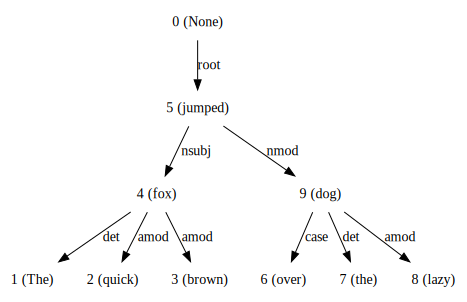

In [49]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

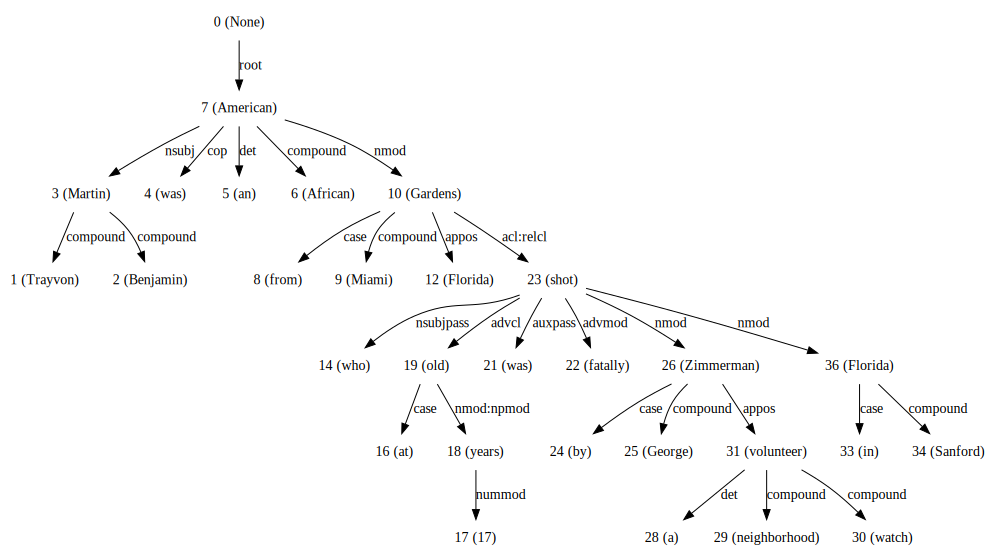

In [56]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [57]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [58]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

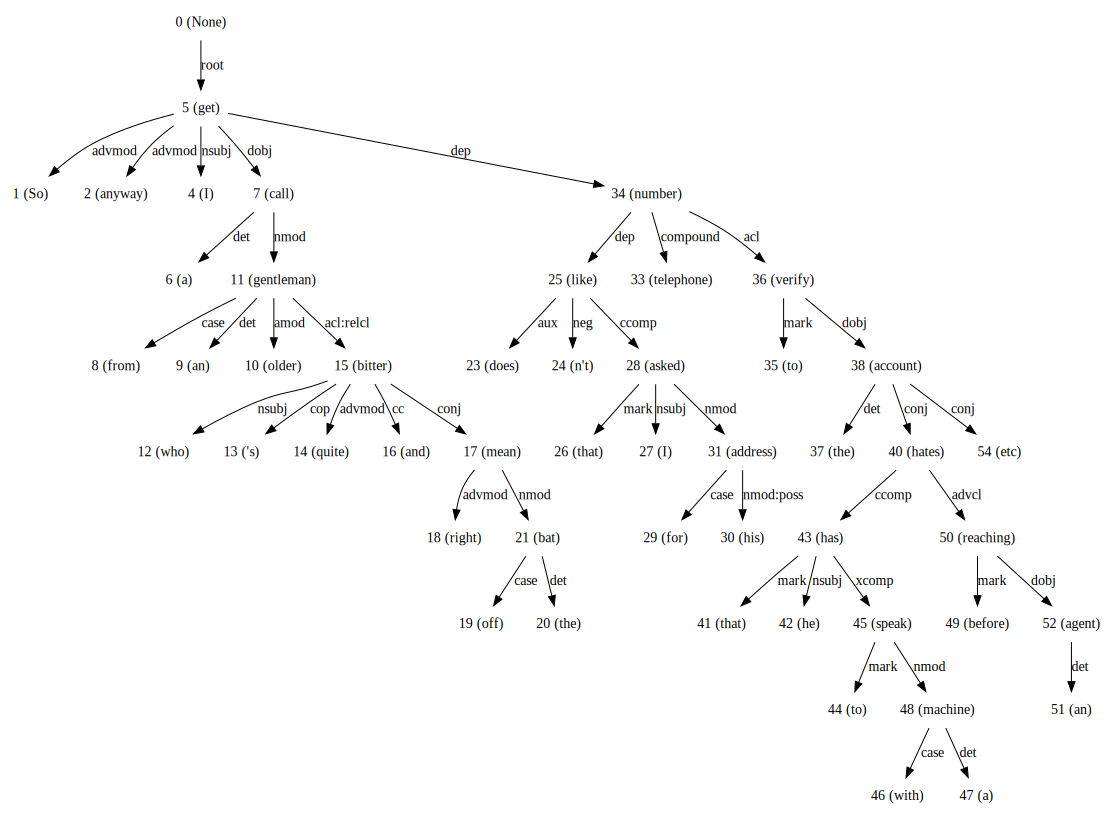

In [59]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

In [55]:
DOSparses = list(stanford.parser.parse_sents(DOSSpeechesDF['sentences'][0])) #Converting the iterator to a list so we can call by index. They are still 
DOSfourthSentParseTree = list(DOSparses[3]) #iterators so be careful about re-running code, without re-running this block
print(DOSfourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NP', [Tree('JJ', ['Terrorist']), Tree('NNS', ['groups'])]), Tree(',', [',']), Tree('NP', [Tree('NP', [Tree('NP', [Tree('RB', ['especially']), Tree('DT', ['the']), Tree('JJ', ['Islamic']), Tree('NN', ['State'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('NNP', ['Iraq'])])])]), Tree('CC', ['and']), Tree('NP', [Tree('NP', [Tree('NP', [Tree('DT', ['the']), Tree('NN', ['Levant'])]), Tree('PRN', [Tree('-LRB-', [Tree('', []), Tree('NP', [Tree('NNP', ['ISIL'])]), Tree('-RRB-', [])])])]), Tree('VP', [Tree('ADVP', [Tree('RB', ['also'])]), Tree('VBN', ['known']), Tree('PP', [Tree('IN', ['as']), Tree('NP', [Tree('NNP', ['ñDaÍeshî'])])])])])]), Tree(',', [','])]), Tree('VP', [Tree('VBP', ['have']), Tree('VP', [Tree('VBN', ['become']), Tree('S', [Tree('ADJP', [Tree('RB', ['increasingly']), Tree('JJ', ['adept']), Tree('PP', [Tree('IN', ['at']), Tree('S', [Tree('VP', [Tree('VBG', ['using']), Tree('NP', [Tree('NP', [Tree('DT', ['the']), Tree('NN', ['

In [56]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [57]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [62]:
treeSubRelation(DOSfourthSentParseTree, 'Terrorist', 'Islamic')

set()

In [ ]:
#I had a lot of trouble finding words that worked for both the treeRelation and treeSubRelation

In [77]:
DOSfourthSentParseTree[0].pretty_print()

                                                                                                                                                                                                 ROOT                                                                                                                                                                                                                          
                                                                                                                                                                                                  |                                                                                                                                                                                                                             
                                                                                                                                                                       

In [82]:
list(DOSparses[1])[0].pretty_print()

                                            ROOT                                                    
                                             |                                                       
                                             S                                                      
  ___________________________________________|____________________________________________________   
 |                                           VP                                                   | 
 |    _______________________________________|__________________________________________          |  
 |   |                  ADJP                                                            |         | 
 |   |      _____________|___________________                                           |         |  
 |   |     |                                 S                                          |         | 
 |   |     |                                 |                                         

In [ ]:
#Dependency parsing and graph representations below

In [69]:
DOSdepParses = list(stanford.depParser.parse_sents(DOSSpeechesDF['sentences'][0])) #Converting the iterator to a list so we can call by index. They are still 
targetSentence = 3
print(' '.join(DOSSpeechesDF['sentences'][0][targetSentence]))

Terrorist groups , especially the Islamic State of Iraq and the Levant ( ISIL ) also known as ñDaÍeshî , have become increasingly adept at using the Internet and information and communications technologies ( ICT ) , along with other tools , to raise money , propagate their messages , recruit individuals , and inspire violent acts .


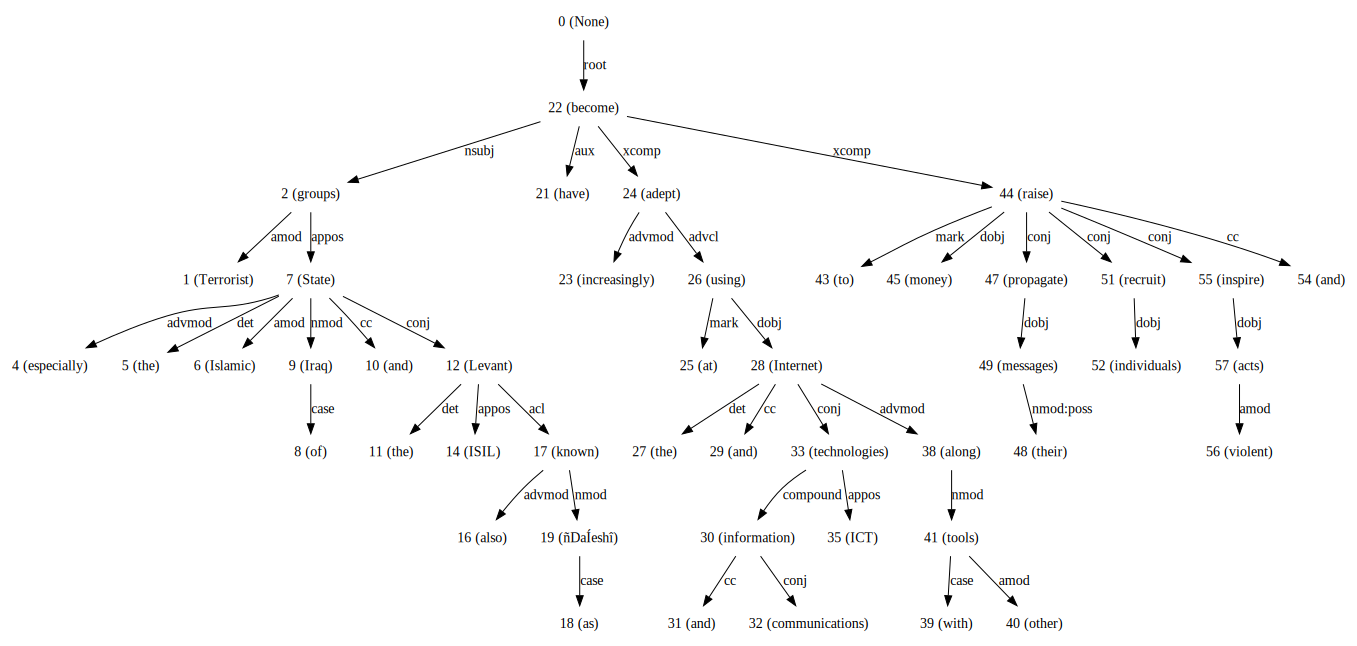

In [70]:
try:
    graph = graphviz.Source(list(DOSdepParses[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

Verbs, and the noun 'State' both are central to the parsing, and dependency parsing of my sentences. It makes sense that the noun 'State' would be so significant, given that international relations revolves around States. 

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [87]:
ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [2.1 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 26.963 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [29.2 sec].
[main] INFO edu.stanford.nlp.pip

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [88]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

In [51]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
TMDepParseTree = list(depParses[3])[0] #iterators so be careful about re-running code, without re-running this block
print(TMDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x119a4e620>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [7]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 3,
                 'lemma': '_',
                 'rel': 'compound',
                 'tag': 'NNP',
                 'word': 'Trayvon'},
             2: {'address': 2,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 3,
                 'lemma': '_',
                 'rel': 'compound',
                 'tag': 'NNP',
     

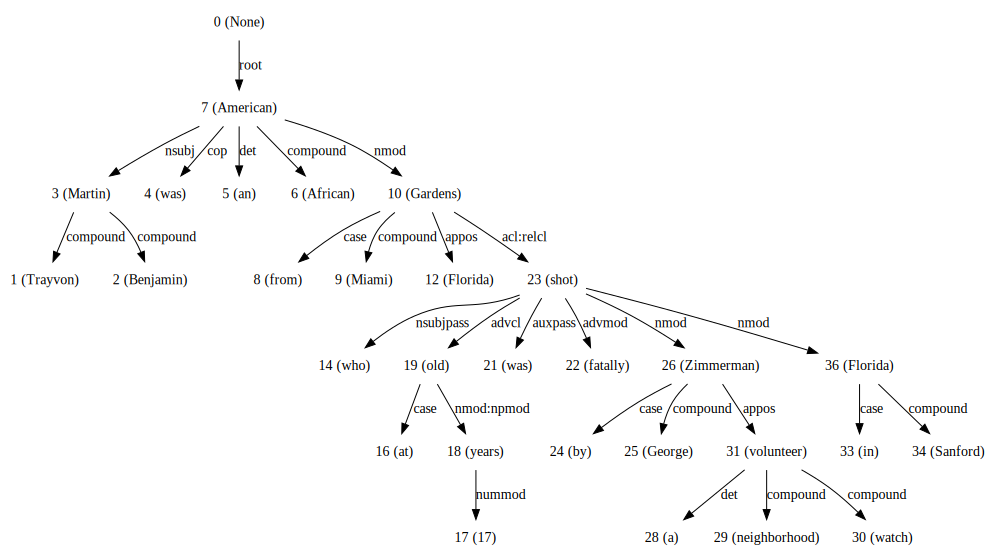

In [52]:
try:
    TMSentGraph = graphviz.Source(TMDepParseTree.to_dot())
except:
    TMSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
TMSentGraph

In [54]:
stanford.startCoreServer()

Starting server on http://localhost:16432 , please wait a few seconds
click Kernel -> Then Interupt to stop              (* ﾟДﾟ)            
Exiting (ノ≧▽≦)ノ


I used the Core Server above, and found it interesting that 'Trayvon Martin' was not linked to 'shot', even though he is, in grammatical terms, the object of the sentence upon which the act took place. Instead, 'shot' is linked to the noun who took the action, 'George Zimmerman', as well as 'African American', which describes Trayvon Martin. The punctuation in the sentence appears to have an influence on this, but I may be wrong. Overall, 'shot' appears to be the epicenter of this sentence, and 'Trayvon Martin' is the most isolated/ the least linked to the rest of the sentence. 

In [ ]:
###

And we can also look for subject, object, target triples in one of the reddit stories.

In [89]:
ieDF = stanford.openIE(redditTopScores['text'][0])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.9 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 19.925 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [21.8 sec].
[main] INFO edu.stanford.nlp.pip

In [90]:
ieDF

,certainty,subject,verb,object
0,1.000000,we,'ll get,calls
1,1.000000,we,Quite often 'll get,calls
2,1.000000,we,often 'll get,calls
3,0.831036,we,coax,direct to TV
4,0.774359,straight analog cable,coax,direct from wall
5,0.774359,analog cable,coax,direct from wall to TV
6,0.774359,straight analog cable,coax,direct to TV
7,1.000000,we,would supply analog cable to,homes
8,0.831036,we,coax,direct from wall
9,0.774359,analog cable,coax,direct from wall


That's almost 200 triples in only:

In [91]:
len(redditTopScores['sentences'][0])

37

sentences and

In [92]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [93]:
ieDF['subject'].value_counts()

I                        48
it                       42
he                       19
He                       18
we                       11
man                       8
old man                   8
call                      4
straight analog cable     4
our booking calendar      4
analog cable              4
letter                    4
my supervisor             3
you                       2
they                      2
TV                        2
his TV set                2
our digital equipment     1
people                    1
our equipment             1
me                        1
handling                  1
repeat offenders          1
Name: subject, dtype: int64

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [94]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

could come                        8
even brought                      5
brought                           5
was                               4
had                               4
speak for                         3
had cable within                  1
So anyway get                     1
complaint in                      1
instantly felt                    1
get                               1
think occasionally about          1
still think occasionally about    1
still think about                 1
do                                1
anyway get                        1
think about                       1
eventually had                    1
've dealt with                    1
felt                              1
speak with                        1
have                              1
get to                            1
took                              1
ask                               1
Name: verb, dtype: int64

and the following objects

In [95]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Mr. Smith                                             4
him                                                   3
call                                                  3
remote for his set top box                            2
simplified remote for his set top box                 2
simplified remote                                     2
remote                                                2
willing                                               2
bad                                                   2
get                                                   2
this                                                  2
cable running again                                   1
speak for bit about account                           1
it                                                    1
her                                                   1
cable running                                         1
cable                                                 1
useless                                         

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [ ]:
stanford.startCoreServer()

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.

In [96]:
DOSieDF = stanford.openIE(DOSSpeechesDF['text'][1])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 18.315 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [20.1 sec].
[main] INFO edu.stanford.nlp.pip

In [97]:
DOSieDF

,certainty,subject,verb,object
0,1.000000,event,happening during,anniversary
1,1.000000,It,is,worth
2,1.000000,It,is,also worth
3,1.000000,event,happening during,25th anniversary
4,1.000000,I,am,honored
5,1.000000,I,have,opportunity speak today
6,1.000000,I,am,Therefore honored
7,1.000000,I,have,opportunity speak
8,1.000000,I,have,opportunity speak with you today
9,1.000000,I,have,opportunity speak with you


In [98]:
len(DOSSpeechesDF['sentences'][1])

60

In [99]:
sum([len(s) for s in DOSSpeechesDF['sentences'][1]])

1749

In [100]:
DOSieDF['subject'].value_counts()

I                                     38
we                                    35
states                                23
We                                    19
GGE report                            14
2015 GGE report                       14
it                                    12
measures                              11
United States                         11
It                                     9
My visit                               9
My first visit                         9
like-minded states                     8
cybersecurity memorandum               8
they                                   7
Similar measures                       7
some                                   7
first office                           5
John Kerry                             5
internet revolution                    5
office                                 5
other nations                          4
our digital future                     4
pillar                                 4
our future      

In [105]:
DOSieDF[DOSieDF['subject'] == 'states']['verb'].value_counts()

work together against    4
work against             4
be                       3
be guided in             2
are                      2
fully realize            1
take seriously           1
realize                  1
take                     1
_ in                     1
act in                   1
be guided by             1
_ during                 1
Name: verb, dtype: int64

In [108]:
DOSieDF[DOSieDF['subject'] == 'states']['object'].value_counts()

threats                                              4
its benefits                                         2
common non-state threats                             2
non-state threats                                    2
common threats                                       2
conflict _                                           1
guided in their use of information by 2015 report    1
guided in their use by 2015 report                   1
2015 report                                          1
guided                                               1
able                                                 1
peacetime                                            1
their use of information                             1
their use                                            1
where able                                           1
cyberspace                                           1
Name: object, dtype: int64